<a href="https://colab.research.google.com/github/superbunny38/MachineLearning/blob/main/CS229MachineLearning/2022AndrewLectureNotes/Probset1/Prob5/Set1Problem5(b)(c).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

**Rights**:

*Assignment made by: Prof. Andrew Ng, Stanford*

 *Assignment solved by: Chaeeun Ryu, SKKU*

In [7]:
#@title Utils
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')



import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

In [2]:
train_path = "/content/ds5_train.csv"
eval_path = "/content/ds5_valid.csv"

In [3]:
pd.read_csv(train_path).head()

,x_1,y
0,-4.029750,-0.420076
1,-2.524577,0.205268
2,2.794617,0.773794
3,1.695904,0.210476
4,-1.458392,0.858475


# (b)
We will now consider the following dataset ($x^{(i)}$ is 1-diemensional). Implement **locally weighted linear regression** using **the normal equations** you derived in Part (a) and using

$$w^{(i)} = exp(-\frac{||x^{(i)}-x||_2^2}{2\tau^2})$$

Train your model using $\tau$ = 0.5 then run your model on validation data, and report the **mean squared error (MSE)**. Finally plot your model's predictions on the validation set (plot the training set with blue 'x' markers and the validation set with a red 'o' markers). Does the model seem to be under- or overfitting?


In [4]:
np.diagflat([1,1,1])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [49]:
def get_mse(y_preds,y):
  mse = 0.0
  for pred, data_y in zip(y_preds, y):
    # print(f"predicted: {pred}, y: {data_y}")
    mse += (data_y-pred)**2
  assert len(y_preds) == len(y)
  mse = mse/len(y_preds)
  return mse

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def main(tau, train_path = train_path, eval_path = eval_path):
    """Problem 5(b): Locally weighted regression (LWR)

    Args:
        tau: Bandwidth parameter for LWR.
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
    """
    # Load training set
    x_train, y_train = load_dataset(train_path, add_intercept=True)

    # *** START CODE HERE ***
    # Fit a LWR model
    clf = LocallyWeightedLinearRegression(tau)
    preds_train = clf.fit(x_train,y_train)

    # Get MSE value on the validation set
    x_val, y_val = load_dataset(eval_path, add_intercept= True)
    preds_val = clf.predict(x_val)
    mse_val = get_mse(preds_val, y_val)
    print(f"MSE for validation data: {mse_val}")

    # Plot validation predictions on top of training set
    x_train_viz, y_train_viz = load_dataset(train_path, add_intercept=False)
    x_val_viz, y_val_viz = load_dataset(eval_path, add_intercept = False)
    
    plt.figure(figsize= (15,10))
    plt.title("Plot validation predictions on top of training set")
    plt.scatter(x_train_viz, y_train_viz, c="blue", marker = "x", label = "train data GT")
    plt.scatter(x_val_viz, preds_val, c = "red", marker = "o", label = "validation data predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    # No need to save predictions

    # Plot data
    plt.figure(figsize= (15,10))
    plt.title("Original Validation data")
    plt.scatter(x_val_viz, y_val_viz, c="blue", marker = "x", label = "validation data GT")
    plt.scatter(x_val_viz, preds_val, c = "red", marker = "o", label = "validation data predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    plt.figure(figsize= (15,10))
    plt.title("Original Train data")
    plt.scatter(x_train_viz, y_train_viz, c="blue", marker = "x", label = "train data GT")
    plt.scatter(x_train_viz, preds_train, c = "red", marker = "o", label = "train data predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
    # *** END CODE HERE ***



class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        """
        
        # *** START CODE HERE ***
        def get_W(point):
          flatten_ = []
          for xi in x:
            f = np.exp(-np.dot(np.transpose(np.subtract(xi,point)),np.subtract(xi,point))/(2*self.tau**2))
            flatten_.append(f)
          return np.diagflat(flatten_)
        self.x, self.y = x,y
        preds = []
        for data_x in x:
          # print(np.transpose(x).shape, get_W(data_x).shape, x.shape)
          first = np.linalg.inv(np.transpose(x)@get_W(data_x)@x)
          second = np.matmul(first, np.transpose(x))@get_W(data_x)
          third = np.matmul(second,y)
          THETA = third
          THETA = THETA.reshape(-1,1)
          #print(THETA.shape)
          #print(np.transpose(THETA).shape)
          pred = np.transpose(THETA)@data_x
          preds.append(pred)
        
        mse = get_mse(preds, y)
        print(f"MSE for train data: {mse}")
        return preds
        # *** END CODE HERE ***

    def predict(self, x):
        """Make predictions given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        def get_W(point):
          flatten_ = []
          for xi in self.x:
            f = np.exp(-np.dot(np.transpose(np.subtract(xi,point)),np.subtract(xi,point))/(2*self.tau**2))
            flatten_.append(f)
          return np.diagflat(flatten_)
          
        preds = []
        for data_x in x:#valid data
          #print(np.transpose(self.x).shape, get_W(data_x).shape, self.x.shape)
          first = np.linalg.inv(np.transpose(self.x)@get_W(data_x)@self.x)
          second = np.matmul(first, np.transpose(self.x))@get_W(data_x)
          third = np.matmul(second,self.y)
          THETA = third
          THETA = THETA.reshape(-1,1)
          #print(THETA.shape)
          #print(np.transpose(THETA).shape)
          pred = np.transpose(THETA)@data_x
          preds.append(pred)
        return preds
        # *** END CODE HERE ***

MSE for train data: [0.32535236]
MSE for validation data: [0.33053127]


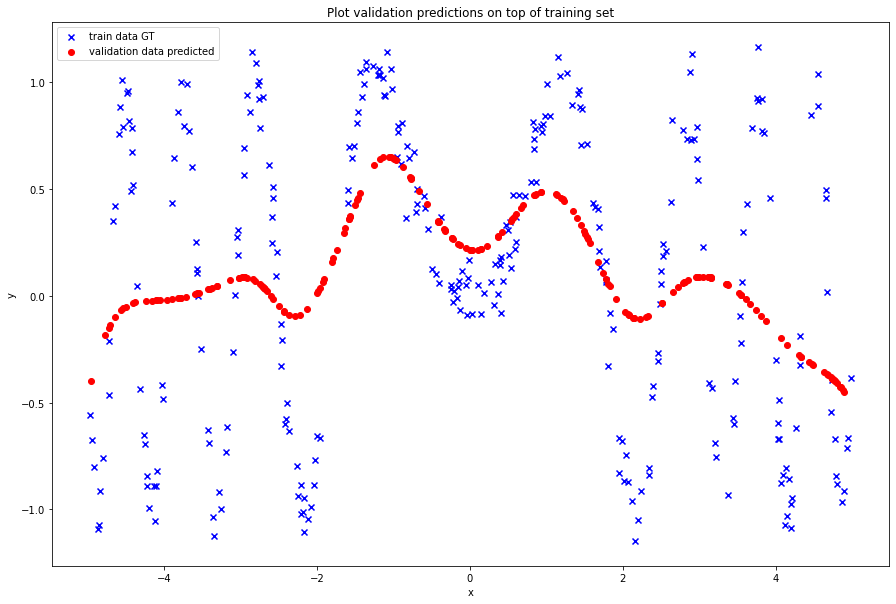

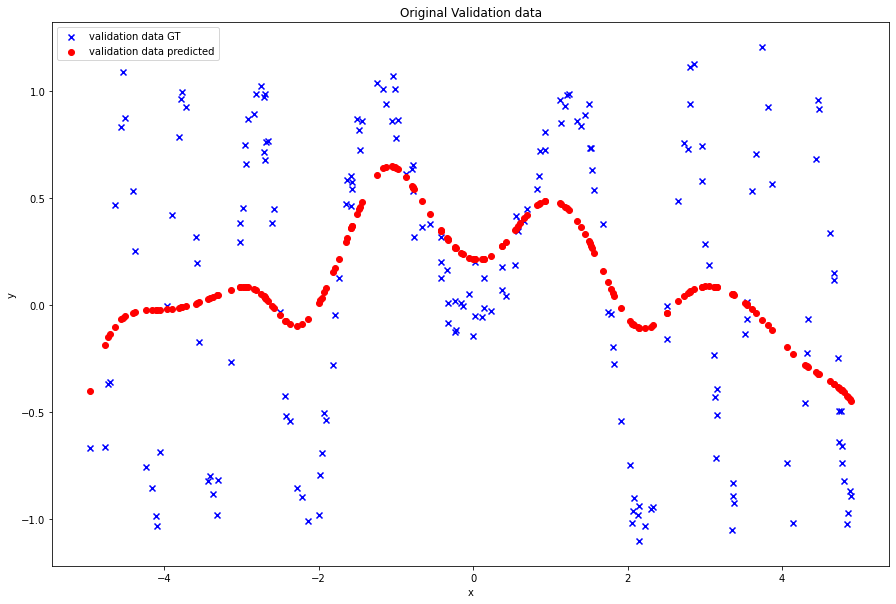

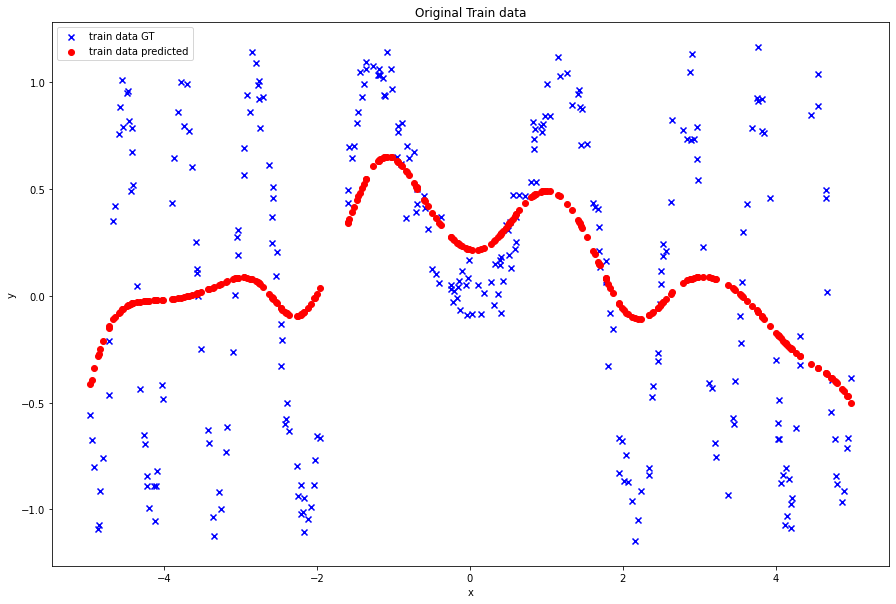

In [79]:
main(tau = 0.5)

### Answer in Text

Does the model seem to be under- or overfitting?

Answer: The model seems to be underfitting, and mse for validation data is 0.3305

# (c)

We will now tune the hyperparameter $\tau$. Find the MSE value of your model on the validation set for each of the values of $\tau$ specified in the code. For each $\tau$, plot your model's predictions on the validation set in the format descrived in part (b). Report the value of $\tau$ which achieves the lowest MSE on the valid split, and finally reportthe MSE on the test split using this $\tau$-value.

In [80]:
tau_values=[3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]
test_path = "/content/ds5_test.csv"

In [85]:
def main(tau_values = tau_values, train_path = train_path, valid_path = eval_path, test_path = test_path, pred_path = "/content/"):
    """Problem 5(b): Tune the bandwidth paramater tau for LWR.
    Args:
        tau_values: List of tau values to try.
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    # Load training set
    x_train, y_train = load_dataset(train_path, add_intercept=True)

    # *** START CODE HERE ***
    # Search tau_values for the best tau (lowest MSE on the validation set)
    lowest_MSE = 99.
    best_tau = 0.
    for tau in tau_values:
      clf = LocallyWeightedLinearRegression(tau)
      preds_train = clf.fit(x_train,y_train)
      x_val, y_val = load_dataset(valid_path, add_intercept= True)
      preds_val = clf.predict(x_val)
      mse_val = get_mse(preds_val, y_val)
      print(f"MSE for validation data (tau: {tau}): {mse_val}")
      if mse_val < lowest_MSE:
        lowest_MSE = mse_val
        best_tau = tau

    # Fit a LWR model with the best tau value
    print(f"Fitting LWR for best tau value({best_tau})")
    best_clf = LocallyWeightedLinearRegression(best_tau)
    preds_train = best_clf.fit(x_train, y_train)

    # Run on the test set to get the MSE value
    x_test, y_test = load_dataset(test_path, add_intercept = True)
    preds_test = best_clf.predict(x_test)

    # Save predictions to pred_path
    print("saving predictions for test dataset..")
    np.savetxt("pred_test.txt",preds_test)


    # Plot data
    # Plot test predictions on top of training set
    x_train_viz, y_train_viz = load_dataset(train_path, add_intercept=False)
    x_test_viz, y_test_viz = load_dataset(test_path, add_intercept = False)
    
    plt.figure(figsize= (15,10))
    plt.title(f"Plot test predictions with best tau value ({best_tau}) on top of training set")
    plt.scatter(x_train_viz, y_train_viz, c="blue", marker = "x", label = "train data GT")
    plt.scatter(x_test_viz, preds_test, c = "red", marker = "o", label = "test data predicted")
    plt.scatter(x_test_viz, y_test_viz, c = "gray", marker = "o", label = "test data GT")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    # *** END CODE HERE ***

MSE for train data: [0.00525482]
MSE for validation data (tau: 0.03): [0.01809616]
MSE for train data: [0.00817036]
MSE for validation data (tau: 0.05): [0.01240008]
MSE for train data: [0.02175835]
MSE for validation data (tau: 0.1): [0.02422459]
MSE for train data: [0.32535236]
MSE for validation data (tau: 0.5): [0.33053127]
MSE for train data: [0.4049815]
MSE for validation data (tau: 1.0): [0.40009595]
MSE for train data: [0.45596601]
MSE for validation data (tau: 10.0): [0.43374392]
Fitting LWR for best tau value(0.05)
MSE for train data: [0.00817036]
saving predictions for test dataset..


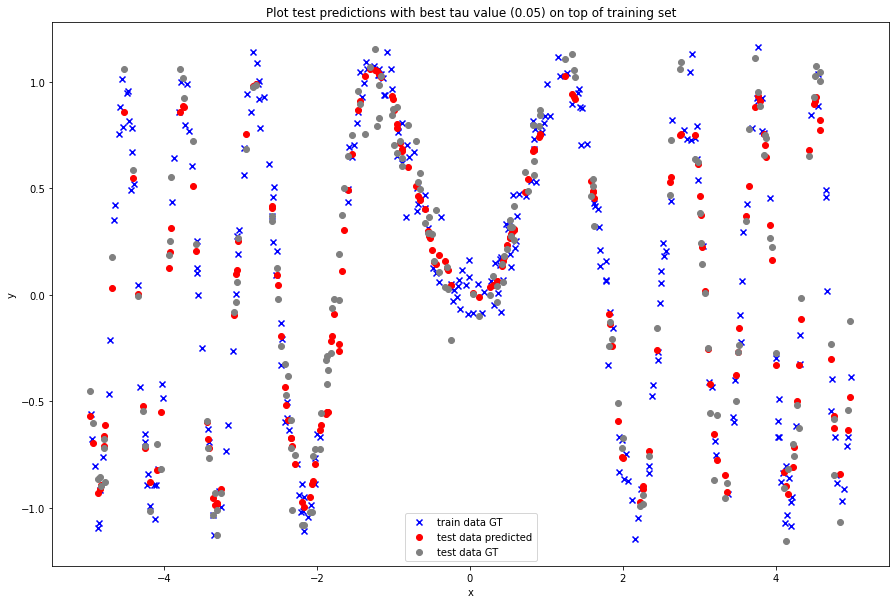

In [86]:
main()

Report on best tau value: 0.05